<a href="https://colab.research.google.com/github/yallapragada/text_similarity/blob/master/sentence_encoding_xlm_mlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple experiments with multilingual sentence encoding using xlm-mlm-100-1280

**In this notebook, I have experimented with the new multilingual model from Facebook using the transformers library. I am particularly interested in testing similarity of sentence representations (obtained from the last layer in encoder) for sentences across different languages**. 

In [0]:
# check cuda version

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
# pip install

!pip install torch torchvision
!pip install transformers
!pip install umap-learn==0.4.0rc1

     |████████████████████████████████| 542kB 13.9MB/s 
     |████████████████████████████████| 1.0MB 51.6MB/s 
     |████████████████████████████████| 3.7MB 18.3MB/s 
     |████████████████████████████████| 870kB 45.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=062b08f621cd8741cfbaf67d36fd1c51ef7b79e7828c409c74a4f1b7690b3fbb
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 2.5MB 44.1MB/s 
     |████████████████████████████████| 942kB 52.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.4.0rc1-cp36-none-any.whl size=63612 sha256=95ad166d606cbc7162654ee2d7266439e6b2db3a588095ae034ada780297231e
  Stored in directory: /root/.cache/pip/wheels/5f/39/f1/70b5ba0a0e6227daff6a1506cc6a84d642d256f407f4e88a90
Successfully built umap-learn
  Found exis

In [0]:
# imports 

from transformers import XLMTokenizer, XLMModel
import torch
from scipy.spatial import distance
import matplotlib.pyplot as plt
import umap
%matplotlib inline

In [0]:
# download pretrained model and create transformers XLMTokenizer and XLMModel
model_name = 'xlm-mlm-100-1280'
tokenizer = XLMTokenizer.from_pretrained(model_name)
model = XLMModel.from_pretrained(model_name)

In [0]:
# check tokenization

text = 'Hello, my dog is cute'
tokenized_text = tokenizer.tokenize(text)
tokenized_text

['Hello</w>', ',</w>', 'my</w>', 'dog</w>', 'is</w>', 'c', 'ute</w>']

In [0]:
# check sentence representation, I am assuming that the first element of last layer represents the contextual vector

input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
outputs = model(input_ids)
last_hidden_states = outputs[0]
last_hidden_states.shape
vector = last_hidden_states[0][0]

In [0]:
# example sentences in different languages

# same sentences in english, spanish and telugu
text_en = 'Wash your hands often with soap and water for at least 20 seconds especially after you have been in a public place, or after blowing your nose, coughing, or sneezing'
text_sp = 'Lávese las manos con frecuencia con agua y jabón durante al menos 20 segundos, especialmente después de haber estado en un lugar público, o después de sonarse la nariz, toser o estornudar'
text_te = 'మీ చేతులను సబ్బు మరియు నీటితో కనీసం 20 సెకన్ల పాటు కడగాలి, ముఖ్యంగా మీరు బహిరంగ ప్రదేశంలో ఉన్న తర్వాత లేదా దగ్గు లేదా తుమ్ము తర్వాత'

# same sentence in english and russian
text2_en = 'Ventilators can allow such patients to breathe'
text2_ru = 'Вентиляторы могут позволить таким пациентам дышать'

# english sentence in active and passive voice
text3_en_act = 'john took that book'
text3_en_pass = 'that book was taken by john'

In [0]:
# get vectors for sentences from output of transforer using last_layer[0][0]

with torch.no_grad():
  input_ids = torch.tensor(tokenizer.encode(text_en, add_special_tokens=True)).unsqueeze(0) 
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_en = last_hidden_states[0][0]

  input_ids = torch.tensor(tokenizer.encode(text_sp, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_sp = last_hidden_states[0][0]

  input_ids = torch.tensor(tokenizer.encode(text_te, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_te = last_hidden_states[0][0]
 
  input_ids = torch.tensor(tokenizer.encode(text2_en, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_en2 = last_hidden_states[0][0]
 
  input_ids = torch.tensor(tokenizer.encode(text2_ru, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_ru2 = last_hidden_states[0][0]
 
  input_ids = torch.tensor(tokenizer.encode(text3_en_act, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_en3_act = last_hidden_states[0][0]
 
  input_ids = torch.tensor(tokenizer.encode(text3_en_pass, add_special_tokens=True)).unsqueeze(0)
  outputs = model(input_ids)
  last_hidden_states = outputs[0]
  vector_en3_pass = last_hidden_states[0][0]

In [0]:
# convert tensor to numpy array

vector_en = vector_en.numpy()
vector_sp = vector_sp.numpy()
vector_te = vector_te.numpy()
vector_ru2 = vector_ru2.numpy()
vector_en2 = vector_en2.numpy()
vector_en3_act = vector_en3_act.numpy()
vector_en3_pass = vector_en3_pass.numpy()

In [0]:
# cosine distances between translations

en_sp_distance = distance.cosine(vector_en, vector_sp)
en_te_distance = distance.cosine(vector_en, vector_te)
sp_te_distance = distance.cosine(vector_sp, vector_te)
en2_ru2_distance = distance.cosine(vector_en2, vector_ru2)

In [0]:
# cosine distances between unrelated sentences

en_ru2_distance = distance.cosine(vector_en, vector_ru2)
en2_sp_distance = distance.cosine(vector_en2, vector_sp)

In [0]:
# cosine distances between same sentences in active and passive voices

en3_act_pass = distance.cosine(vector_en3_act, vector_en3_pass)

In [0]:
print(en_te_distance, en_sp_distance, sp_te_distance)
print(en2_ru2_distance)
print(en_ru2_distance, en2_sp_distance)
print(en3_act_pass)

0.42409777641296387 0.331012487411499 0.43656814098358154
0.3843461871147156
0.5892896950244904 0.5824634432792664
0.17873311042785645


## Perform dimensionality reduction using UMAP and visualize

In [0]:
vectors = [vector_en, vector_sp, vector_te, vector_en2, vector_ru2, vector_en3_act, vector_en3_pass]
colors = [1, 1, 1, 2, 2, 3, 3]

In [0]:
embedding = umap.UMAP(n_components=2, metric='euclidean').fit(vectors)
print(embedding.embedding_.shape)
x, y = zip(*embedding.embedding_)
print(x, y)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1603: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(7, 2)
(20.618341, 20.66686, 19.998617, 19.955313, 19.311993, 19.111195, 18.726149) (13.347752, 12.44908, 12.585335, 13.975017, 13.260807, 14.643019, 13.936687)


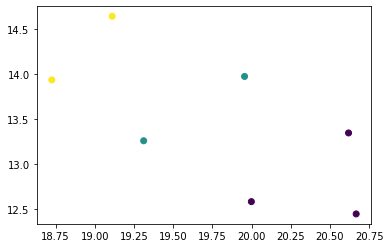

In [0]:
plt.scatter(x,y, c=colors)